In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

Train using Best Probe (seen so far)

In [2]:
# features created using extract_features_simple.py
# load in train data.
X_train = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/short_train/X.npy')
y_train = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/short_train/y.npy')

# load in test data.
X_test = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/short_test/X.npy')
y_test = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/short_test/y.npy')

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((83572, 1544), (83572,), (10236, 1544), (10236,))

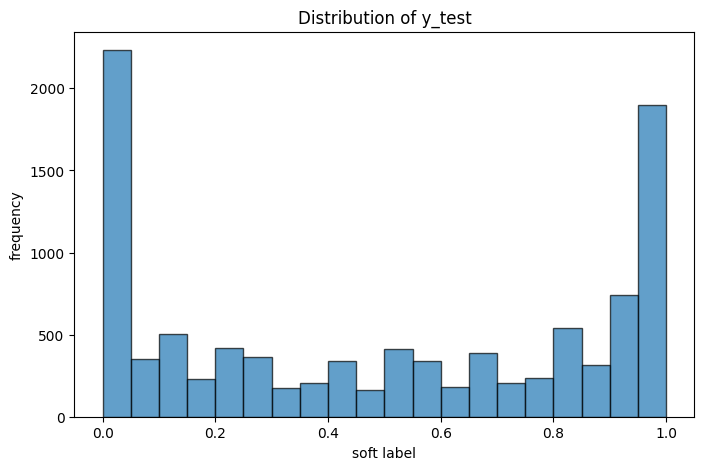

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_test, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of y_test")
plt.xlabel("soft label")
plt.ylabel("frequency")
plt.show()


In [4]:
### Train MLP.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((83572, 1544), (83572,), (10236, 1544), (10236,))

#### Create Custom MLP (soft labels)

In [4]:
import torch
import torch.nn as nn                        # for neural network layers, loss functions, etc.
from torch.utils.data import Dataset, DataLoader, random_split      # for batching and shuffling datasets
import torch.optim as optim

In [5]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. Calibration split -----
calib_frac = 0.2
calib_size = int(len(train_dataset) * calib_frac)
train_size = len(train_dataset) - calib_size

train_dataset, calib_dataset = random_split(train_dataset, [train_size, calib_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
calib_loader = DataLoader(calib_dataset, batch_size=64, shuffle=False)

In [6]:
# ----- 4. MLP Model -----
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),  # First layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Linear(200, 200),       # Second layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Linear(200, 1)         # Output layer
            # nn.Sigmoid()               # Sigmoid for binary cross-entropy with soft targets
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=1544)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for soft binary targets
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [7]:
# ----- 6. Training Loop -----
num_epochs = 100  # Maximum of 10,000 epochs
batch_size = 128    # Batch size of 128
patience = 5      # Early stopping patience

agg_train_loss = []
agg_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_preds = model(val_X)
            val_loss.append(criterion(val_preds, val_y).item())
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    agg_train_loss.append(mean_train_loss)
    agg_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {mean_train_loss:.4f}, Val Loss: {mean_val_loss:.4f}")

    # Early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.6402, Val Loss: 0.6276
Epoch 2, Train Loss: 0.6203, Val Loss: 0.6199
Epoch 3, Train Loss: 0.6131, Val Loss: 0.6152
Epoch 4, Train Loss: 0.6078, Val Loss: 0.6139
Epoch 5, Train Loss: 0.6030, Val Loss: 0.6131


: 

In [ ]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class PlattCalibrator(nn.Module):
    """p = sigmoid(a * logit + b)"""
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.zeros(1))
    def forward(self, logits):         # returns *logits* after affine map
        return self.a * logits + self.b
    def predict_proba(self, logits):   # returns calibrated probabilities
        return torch.sigmoid(self.forward(logits))

@torch.no_grad()
def collect_logits_and_labels(model, loader, device="cpu"):
    model.eval()
    all_logits, all_y = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)              # [B,1] logits
        all_logits.append(logits.squeeze(1).cpu())
        all_y.append(y.squeeze(1).cpu())  # y can be soft in [0,1]
    return torch.cat(all_logits), torch.cat(all_y)

# After training the base model:
device = next(model.parameters()).device
logits_cal, y_cal = collect_logits_and_labels(model, calib_loader, device)

calibrator = PlattCalibrator().to(device)
bce_logits = nn.BCEWithLogitsLoss()  # proper for soft labels too
opt = optim.LBFGS(calibrator.parameters(), lr=1.0, max_iter=100, line_search_fn="strong_wolfe")

def closure():
    opt.zero_grad()
    z = calibrator(logits_cal.to(device))  # affine logits
    loss = bce_logits(z, y_cal.to(device))
    loss.backward()
    return loss

opt.step(closure)

print(f"Platt params: a={calibrator.a.item():.4f}, b={calibrator.b.item():.4f}")


Platt params: a=1.0848, b=0.0164


In [ ]:
# use the calibrated predictor for inference.
@torch.no_grad()
def predict_calibrated_proba(model, calibrator, X, device="cpu"):
    model.eval()
    X = X.to(device)
    logits = model(X)
    return calibrator.predict_proba(logits).squeeze(1)

# Example on the test set:
probs = []
ys = []
with torch.no_grad():
    for X, y in val_loader:
        p = predict_calibrated_proba(model, calibrator, X, device)
        probs.append(p.cpu())
        ys.append(y.squeeze(1).cpu())
calibrated_probs = torch.cat(probs)
ys = torch.cat(ys)


In [ ]:
ys = np.load("/dccstor/gma2/jhjenny9/search-and-learn/training-res/true_labels.npy")
calibrated_probs = np.load("/dccstor/gma2/jhjenny9/search-and-learn/training-res/calibrated_probs.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

((10236,), (10236,))

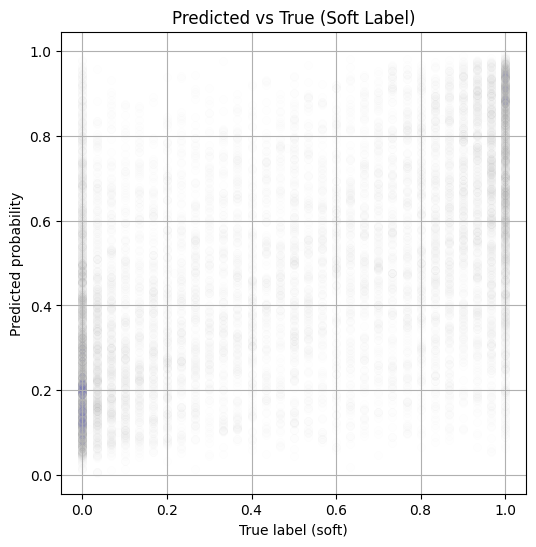

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(ys, calibrated_probs, alpha=0.005)
plt.xlabel("True label (soft)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

Load in test set.

In [ ]:
# load in test data.
csv_path = '/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_combined_week12_short.csv'
df_test_short = pd.read_csv(csv_path)
# remove (old) calibrated_probs column.
df_test_short = df_test_short.drop(columns=['calibrated_probs'])
df_test_short.head(), df_test_short.shape

# load in train data.
# csv_path = '/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_combined_week12_short.csv'
# df_train_short = pd.read_csv(csv_path)
# df_train_short.head()

(                                             problem       method    N  \
 0  Given the functions $f(x) = \log_a(1+x)$ and $...  beam_search  2.0   
 1  How many two-digit positive integers are congr...  beam_search  2.0   
 2  The molecular weight of a certain substance is...  beam_search  2.0   
 3  Given that \(1 \leq x, y, z \leq 6\), how many...  beam_search  2.0   
 4  Dilan, Martha, Phillip, and Veronica went to t...  beam_search  2.0   
 
    beam_width  max_iteration   sl  beam_tc  beam_latency  sb_idx  \
 0         2.0           40.0  0.4   2181.0          8.38    4300   
 1         2.0           40.0  0.0    649.0          2.93    4759   
 2         2.0           40.0  0.0    800.0          3.45    8591   
 3         2.0           40.0  0.0    805.0          2.70    3763   
 4         2.0           40.0  0.0    452.0          1.81    2140   
 
                 bin  method_beam_search  method_maj  method_naive  \
 0  (0.0333, 0.0667]                   1           0          

In [17]:
df_test_short['calibrated_probs'] = calibrated_probs

bin
(-0.001, 0.0333]     17
(0.0333, 0.0667]    120
(0.0667, 0.1]       282
(0.1, 0.133]        363
(0.133, 0.167]      424
(0.167, 0.2]        400
(0.2, 0.233]        438
(0.233, 0.267]      412
(0.267, 0.3]        433
(0.3, 0.333]        432
(0.333, 0.367]      407
(0.367, 0.4]        426
(0.4, 0.433]        422
(0.433, 0.467]      409
(0.467, 0.5]        418
(0.5, 0.533]        412
(0.533, 0.567]      385
(0.567, 0.6]        397
(0.6, 0.633]        375
(0.633, 0.667]      378
(0.667, 0.7]        385
(0.7, 0.733]        344
(0.733, 0.767]      337
(0.767, 0.8]        317
(0.8, 0.833]        305
(0.833, 0.867]      300
(0.867, 0.9]        315
(0.9, 0.933]        271
(0.933, 0.967]      243
(0.967, 1.0]         69
Name: count, dtype: int64


/tmp/ipykernel_538355/2530322131.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test_short.groupby("bin").agg(


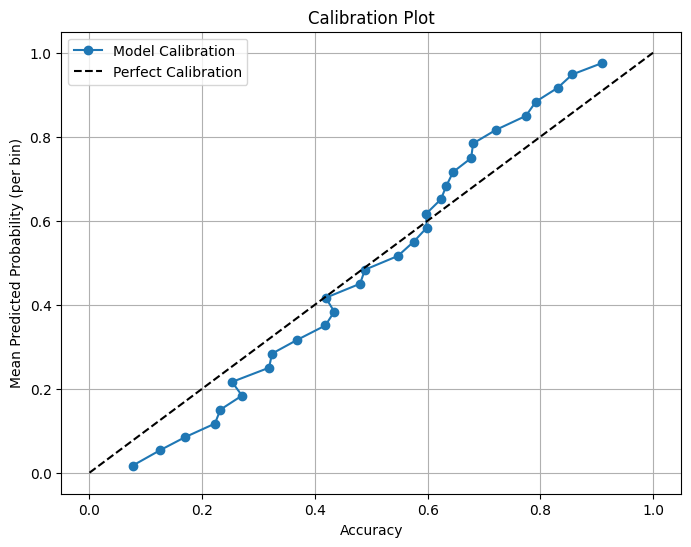

In [15]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test_short["bin"] = pd.cut(calibrated_probs, bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test_short.groupby("bin").agg(
    avg_pred_prob=("calibrated_probs", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

bin
(-0.001, 0.0333]    454
(0.0333, 0.0667]    628
(0.0667, 0.1]       442
(0.1, 0.133]        326
(0.133, 0.167]      285
(0.167, 0.2]        233
(0.2, 0.233]        193
(0.233, 0.267]      179
(0.267, 0.3]        128
(0.3, 0.333]        142
(0.333, 0.367]      142
(0.367, 0.4]        117
(0.4, 0.433]        123
(0.433, 0.467]      109
(0.467, 0.5]        123
(0.5, 0.533]        134
(0.533, 0.567]      145
(0.567, 0.6]        126
(0.6, 0.633]        151
(0.633, 0.667]      150
(0.667, 0.7]        142
(0.7, 0.733]        162
(0.733, 0.767]      157
(0.767, 0.8]        157
(0.8, 0.833]        177
(0.833, 0.867]      173
(0.867, 0.9]        170
(0.9, 0.933]        182
(0.933, 0.967]      205
(0.967, 1.0]        155
Name: count, dtype: int64


/tmp/ipykernel_3780516/1952915704.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test_beam_numina.groupby("bin").agg(


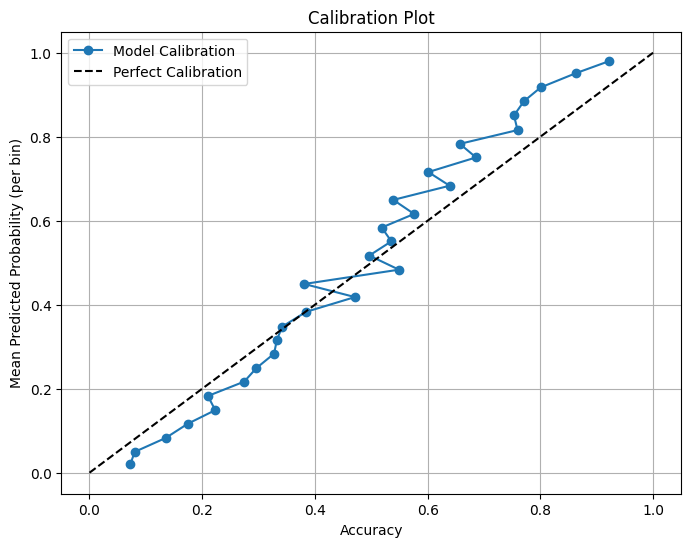

In [ ]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test_beam_numina["bin"] = pd.cut(calibrated_probs, bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test_beam_numina.groupby("bin").agg(
    avg_pred_prob=("calibrated_probs", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

Join Beam with BoN/MV (and additional beam data from the numina-cot-16000 experiment).

In [ ]:
df_train_downsamp6 = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv')
df_test_downsamp6 = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp6.csv')

df_train_downsamp6.shape, df_test_downsamp6.shape

((92058, 10), (10230, 10))

2/3 of the data will come from the downsample-6 experiment, 1/3 will come from the new beam experiment.

In [ ]:
df_train_beam_numina['method_beam_search'] = 1
df_train_beam_numina['method_maj'] = 0
df_train_beam_numina['method_naive'] = 0
df_train_beam_numina['method_weighted'] = 0

df_test_beam_numina['method_beam_search'] = 1
df_test_beam_numina['method_maj'] = 0
df_test_beam_numina['method_naive'] = 0
df_test_beam_numina['method_weighted'] = 0


In [ ]:
df_train_downsamp6['beam_width'] = np.where(df_train_downsamp6['method_beam_search'] == 1, 4, 0)
df_train_downsamp6['max_iteration'] = np.where(df_train_downsamp6['method_beam_search'] == 1, 40, 0)
df_test_downsamp6['beam_width'] = np.where(df_test_downsamp6['method_beam_search'] == 1, 4, 0)
df_test_downsamp6['max_iteration'] = np.where(df_test_downsamp6['method_beam_search'] == 1, 40, 0)
df_train_downsamp6.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,beam_width,max_iteration
0,"""$a \neq 2$"" is the condition for ""line $l_1: ...",16,0.566667,267,False,True,False,False,majority,0,0,0
1,"""$a \neq 2$"" is the condition for ""line $l_1: ...",16,0.866667,267,False,False,True,False,naive,0,0,0
2,"""$a \neq 2$"" is the condition for ""line $l_1: ...",4,0.633333,267,False,False,True,False,naive,0,0,0
3,"""$a \neq 2$"" is the condition for ""line $l_1: ...",4,0.433333,267,False,True,False,False,majority,0,0,0
4,"""$a \neq 2$"" is the condition for ""line $l_1: ...",2,0.533333,267,False,False,False,True,weighted,0,0,0


In [ ]:
# df_train_downsamp6 = df_train_downsamp6.drop(columns=["question_length"])
# df_test_downsamp6 = df_test_downsamp6.drop(columns=["question_length"])
df_train_downsamp6 = df_train_downsamp6.rename(columns={"question": "problem"})
df_test_downsamp6 = df_test_downsamp6.rename(columns={"question": "problem"})
df_train_downsamp6.head()

,problem,N,sl,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,beam_width,max_iteration
0,"""$a \neq 2$"" is the condition for ""line $l_1: ...",16,0.566667,False,True,False,False,majority,0,0,0
1,"""$a \neq 2$"" is the condition for ""line $l_1: ...",16,0.866667,False,False,True,False,naive,0,0,0
2,"""$a \neq 2$"" is the condition for ""line $l_1: ...",4,0.633333,False,False,True,False,naive,0,0,0
3,"""$a \neq 2$"" is the condition for ""line $l_1: ...",4,0.433333,False,True,False,False,majority,0,0,0
4,"""$a \neq 2$"" is the condition for ""line $l_1: ...",2,0.533333,False,False,False,True,weighted,0,0,0


combine datasets.

In [ ]:
df_train_combined = pd.concat([df_train_beam_numina, df_train_downsamp6], ignore_index=True)
df_test_combined = pd.concat([df_test_beam_numina, df_test_downsamp6], ignore_index=True)

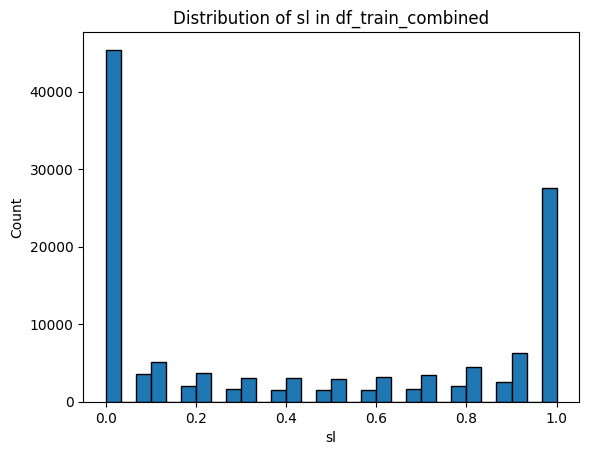

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_train_combined['sl'], bins=30, edgecolor='k')
plt.xlabel('sl')
plt.ylabel('Count')
plt.title('Distribution of sl in df_train_combined')
plt.show()

In [ ]:
def filter_pct_sl0_sl1(df, pct0=0.2, pct1=0.2):
    sl0 = df[df['sl'] == 0]
    sl1 = df[df['sl'] == 1]
    n_remove0 = int(pct0 * len(sl0))
    n_remove1 = int(pct1 * len(sl1))
    drop_idx0 = sl0.sample(n=n_remove0, random_state=42).index
    drop_idx1 = sl1.sample(n=n_remove1, random_state=42).index
    return df.drop(drop_idx0.union(drop_idx1))

df_train_combined_short = filter_pct_sl0_sl1(df_train_combined, pct0=0.7, pct1=0.60)
df_train_combined.shape, df_train_combined_short.shape

df_test_combined_short = filter_pct_sl0_sl1(df_test_combined, pct0=0.7, pct1=0.60)
df_test_combined.shape, df_test_combined_short.shape

((16240, 15), (10236, 15))

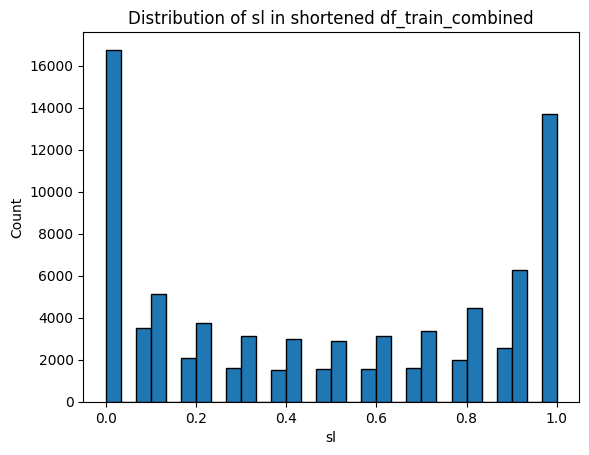

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_train_combined_short['sl'], bins=30, edgecolor='k')
plt.xlabel('sl')
plt.ylabel('Count')
plt.title('Distribution of sl in shortened df_train_combined')
plt.show()

In [ ]:
# df_train_combined.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_combined_week12.csv", index=False)
# df_test_combined.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_combined_week12.csv", index=False)
# df_train_combined_short.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_combined_week12_short.csv", index=False)
# df_test_combined_short.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_combined_week12_short.csv", index=False)

- combine df_train for beam_numina and downsamp6.

- combine df_test for beam_numina and downsamp6.

- create feature embeddings using extract features simple.

- train model (optional: calibrate model).

- format test_set for beam_numina and downsamp6 (aka, add tc + latency or beam_tc + beam_latency).

In [12]:
# created using concatenate_completions.py.
bon_token_counts = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/bon_token_counts_16000.csv')
bon_token_counts.head()
# df_test = df_test.merge(bon_token_counts, on="question", how="left") # change df_test to have appropriate columns (beam_width, max_iteration, etc.)
# df_test.head()

,problem,completion_tokens
0,Through the midpoint \(M\) of side \(BC\) of p...,"[456, 379, 547, 438, 475, 981, 397, 459, 590, ..."
1,Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...,"[513, 2048, 524, 614, 507, 545, 531, 575, 717,..."
2,"Let $a,$ $b,$ $c$ be positive real numbers suc...","[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
3,Given that the graph of the quadratic function...,"[1016, 731, 886, 1084, 828, 682, 822, 863, 837..."
4,"Three circles $\mathcal{K}_1$ , $\mathcal{K}...","[620, 629, 706, 678, 703, 573, 516, 641, 831, ..."


In [9]:
df_test_short['beam_latency'].isna().sum() # get rid of beam-search problems with no latency.

7686

In [18]:
df_test_short_bon = df_test_short[df_test_short["method_beam_search"] == 0]

In [19]:
df_test_short_bon.head(), df_test_short_bon.shape # combine this with token counts and latencies.

(                                                problem    method     N  \
 2550  "$x < 2$" is the condition for "${\log_2}x < 1...  majority   8.0   
 2551  "$x < 2$" is the condition for "${\log_2}x < 1...  majority  16.0   
 2552  "$x < 2$" is the condition for "${\log_2}x < 1...     naive   2.0   
 2553  "$x < 2$" is the condition for "${\log_2}x < 1...  weighted   8.0   
 2554  "$x < 2$" is the condition for "${\log_2}x < 1...  weighted   2.0   
 
       beam_width  max_iteration        sl  beam_tc  beam_latency  sb_idx  bin  \
 2550         0.0            0.0  0.200000      NaN           NaN       4  NaN   
 2551         0.0            0.0  0.233333      NaN           NaN       4  NaN   
 2552         0.0            0.0  0.533333      NaN           NaN       4  NaN   
 2553         0.0            0.0  0.433333      NaN           NaN       4  NaN   
 2554         0.0            0.0  0.533333      NaN           NaN       4  NaN   
 
       method_beam_search  method_maj  method_na

In [34]:
bon_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/softlabel_predictor_df.csv")
bon_df.shape # this one stores potential token counts.

(75000, 12)

In [ ]:
# read predictor_df from csv.
predictor_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/df_bon_beam_softlabels.csv")
predictor_df = predictor_df.rename(columns={"question": "problem"})
predictor_df.head(), predictor_df.shape

(                                             problem  \
 0  Convert the point $(0,3)$ in rectangular coord...   
 1  Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...   
 2  If $f(x) = \frac{3x-2}{x-2}$, what is the valu...   
 3  How many positive whole-number divisors does 1...   
 4  The results of a cross-country team's training...   
 
                                                score  \
 0  [1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...   
 1  [0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...   
 2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
 3  [0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...   
 4  [0.9609375, 0.99609375, 0.99609375, 0.9921875,...   
 
                                    completion_tokens  sb_idx    sl  N  \
 0  [271, 290, 269, 220, 220, 403, 261, 310, 260, ...       0  0.64  2   
 1  [1064, 872, 964, 654, 831, 680, 1384, 832, 103...       1  0.30  2   
 2  [432, 256, 460, 509, 505, 462, 437, 512, 360, ...       2  0.92  2   
 3  [441, 382, 4

In [ ]:
predictor_df.shape # bon test set.

(10000, 10)

In [40]:
predictor_df.head()

,problem,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method,time
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,0.64,2,161,561,weighted,3.56
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,0.30,2,217,1936,weighted,7.81
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,weighted,2.20
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,0.92,2,54,823,weighted,1.61
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,0.64,2,731,783,weighted,2.29


In [20]:
predictor_df['N'].value_counts()

N
2     2000
4     2000
8     2000
16    2000
32    2000
Name: count, dtype: int64

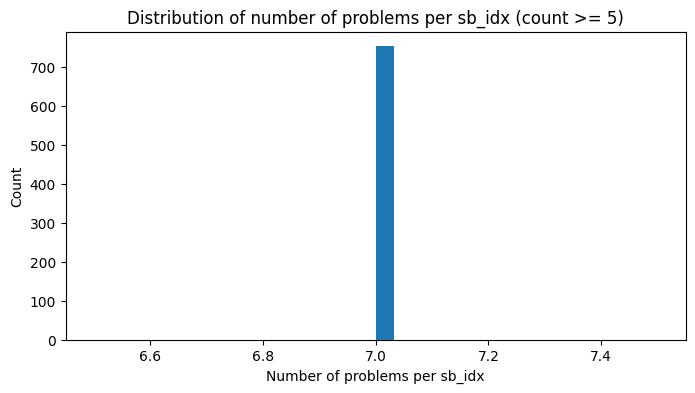

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df_test_beam_numina = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_test_beam_numina.csv")
sb_idx_counts = df_test_beam_numina.groupby("sb_idx").size()
filtered_counts = sb_idx_counts[sb_idx_counts > 1]
plt.figure(figsize=(8,4))
plt.hist(filtered_counts, bins=30)
plt.xlabel("Number of problems per sb_idx")
plt.ylabel("Count")
plt.title("Distribution of number of problems per sb_idx (count >= 5)")
plt.show()

In [6]:
df_beam_filtered = df_test_beam_numina[df_test_beam_numina["sb_idx"].isin(filtered_counts.index)]

In [7]:
df_beam_filtered.shape

(5264, 9)

In [ ]:
beam_test_data = df_beam_filtered

# save beam_test_data to csv.
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/week-12-beam-test-data.csv"
# beam_test_data.to_csv(output_file, index=False)

# Routing

In [36]:
# beam test set.
df_test_beam_numina = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_test_beam_numina.csv")
df_test_beam_numina.shape

# bon test data.
df_test_bon_math500 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/df_bon_beam_softlabels.csv")
df_test_bon_math500.shape

(10000, 10)

In [86]:
df_test_beam_numina.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763


In [24]:
df_test_beam_numina = df_test_beam_numina.rename(columns={"beam_tc": "token_count", "beam_latency": "time"})
df_test_beam_numina.head()

,problem,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763


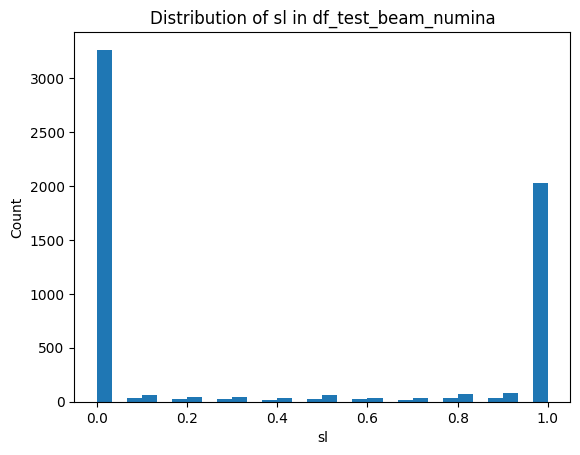

In [30]:
plt.hist(df_test_beam_numina["sl"], bins=30)
plt.xlabel("sl")
plt.ylabel("Count")
plt.title("Distribution of sl in df_test_beam_numina")
plt.show()


Questions are not shared between beam and bon:
- questions in the bon dataset will be routing between BoN and beam.
- questions in beam (this dataset create new variations of beam) will be routing between beam.

In [37]:
df_test_bon_math500["beam_width"] = df_test_bon_math500["method"].apply(lambda x: 4 if x == "beam_search" else 0)
df_test_bon_math500["max_iteration"] = df_test_bon_math500["method"].apply(lambda x: 40 if x == "beam_search" else 0)
df_test_bon_math500.head()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method,time,beam_width,max_iteration
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,0.64,2,161,561,weighted,3.56,0,0
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,0.30,2,217,1936,weighted,7.81,0,0
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,weighted,2.20,0,0
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,0.92,2,54,823,weighted,1.61,0,0
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,0.64,2,731,783,weighted,2.29,0,0


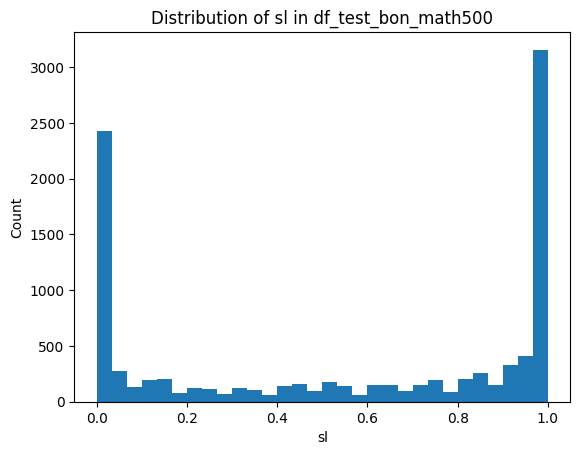

In [38]:
plt.hist(df_test_bon_math500["sl"], bins=30)
plt.xlabel("sl")
plt.ylabel("Count")
plt.title("Distribution of sl in df_test_bon_math500")
plt.show()

In [51]:
# we will exclusively use the harder questions from math500.

def filter_pct_sl0_sl1(df, pct0=0.0, pct1=0.2):
    sl0 = df[df['sl'] == 0]
    sl1 = df[df['sl'] == 1]
    n_remove0 = int(pct0 * len(sl0))
    n_remove1 = int(pct1 * len(sl1))
    drop_idx0 = sl0.sample(n=n_remove0, random_state=42).index
    drop_idx1 = sl1.sample(n=n_remove1, random_state=42).index
    return df.drop(drop_idx0.union(drop_idx1))

df_test_bon_math500_short = filter_pct_sl0_sl1(df_test_bon_math500, pct0=0.6, pct1=1)
df_test_bon_math500_short.shape


(5844, 12)

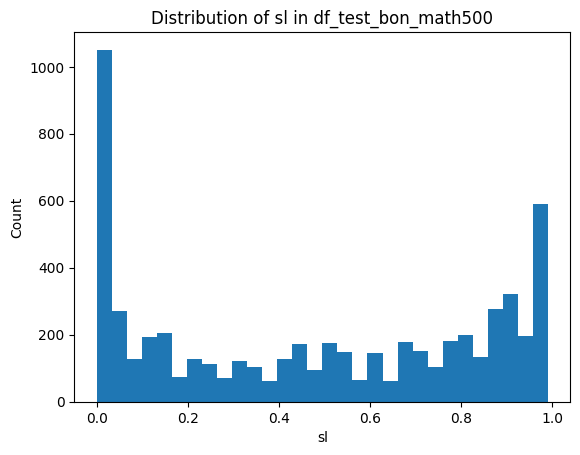

In [52]:
plt.hist(df_test_bon_math500_short["sl"], bins=30)
plt.xlabel("sl")
plt.ylabel("Count")
plt.title("Distribution of sl in df_test_bon_math500")
plt.show()

In [ ]:
# test data. beam and bon.
df_test_beam_numina.shape, df_test_bon_math500_short.shape

((6010, 9), (5844, 12))

In [ ]:
df_test_bon_math500_final = df_test_bon_math500_short.drop(columns=["score", "completion_tokens", "question_length"])
df_test_bon_math500_final.head()

,question,sb_idx,sl,N,token_count,method,time,beam_width,max_iteration
0,"Convert the point $(0,3)$ in rectangular coord...",0,0.64,2,561,weighted,3.56,0,0
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,1,0.30,2,1936,weighted,7.81,0,0
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",2,0.92,2,688,weighted,2.20,0,0
3,How many positive whole-number divisors does 1...,3,0.92,2,823,weighted,1.61,0,0
4,The results of a cross-country team's training...,4,0.64,2,783,weighted,2.29,0,0


In [61]:
df_test_beam_numina = df_test_beam_numina.rename(columns={"beam_tc": "token_count", "beam_latency": "time", "problem": "question"})
df_test_beam_numina.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763


In [62]:
df_test_heart = pd.concat([df_test_beam_numina, df_test_bon_math500_final], ignore_index=True)
df_test_heart.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763


In [ ]:
df_test_heart.shape

(11854, 9)

In [91]:
df_test_heart['N'].value_counts()

N
4.0     2805
16.0    2499
32.0    2324
2.0     2260
8.0     1966
Name: count, dtype: int64

In [104]:
# df_test_heart = pd.get_dummies(df_test_heart, columns=["method"])
# df_test_heart = df_test_heart.rename(columns={"question": "problem"})
df_test_heart.head()

def decode_method(row):
    if row["method_majority"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
df_test_heart["method"] = df_test_heart.apply(decode_method, axis=1)

In [ ]:
# save test set to csv.
# df_test_heart.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/heart/df_test_heart.csv", index=False)

/tmp/ipykernel_904152/320156153.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/tmp/ipykernel_904152/320156153.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")


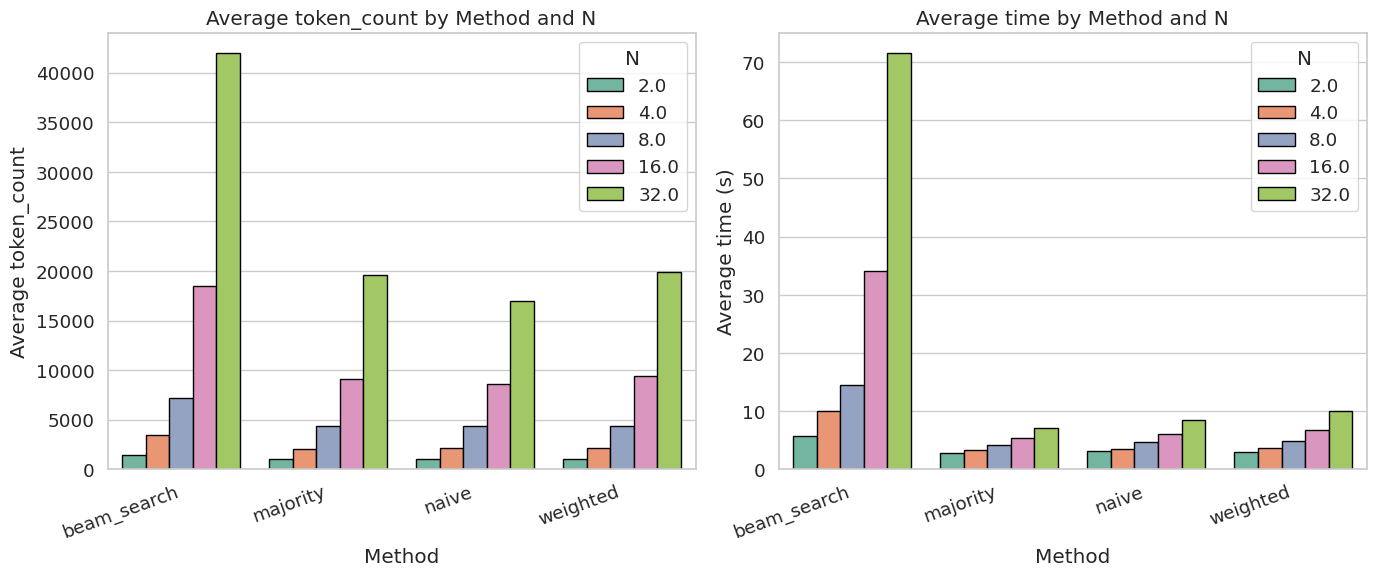

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

palette = sns.color_palette("Set2", n_colors=len(df_test_heart["N"].unique()))

# token_count plot
df_token = df_test_heart.groupby(["method", "N"])["token_count"].mean().reset_index()
sns.barplot(
    data=df_token,
    x="method",
    y="token_count",
    hue="N",
    ax=axs[0],
    palette=palette,
    edgecolor="black"
)
axs[0].set_ylabel("Average token_count")
axs[0].set_xlabel("Method")
axs[0].set_title("Average token_count by Method and N")
axs[0].legend(title="N", loc="upper right", frameon=True)

# time plot
df_time = df_test_heart.groupby(["method", "N"])["time"].mean().reset_index()
sns.barplot(
    data=df_time,
    x="method",
    y="time",
    hue="N",
    ax=axs[1],
    palette=palette,
    edgecolor="black"
)
axs[1].set_ylabel("Average time (s)")
axs[1].set_xlabel("Method")
axs[1].set_title("Average time by Method and N")
axs[1].legend(title="N", loc="upper right", frameon=True)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

plt.tight_layout()
plt.show()



Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.


In [166]:
df_test_heart.head()

,problem,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_majority,method_naive,method_weighted,method,calibrated_probs
0,Given the functions $f(x) = \log_a(1+x)$ and $...,2.0,2.0,40.0,0.4,2181,8.38,4300,True,False,False,False,beam_search,0.151159
1,Given that the sum of the first $n$ terms of a...,2.0,2.0,40.0,0.0,1834,5.00,3949,True,False,False,False,beam_search,0.336354
2,How many two-digit positive integers are congr...,2.0,2.0,40.0,0.0,649,2.93,4759,True,False,False,False,beam_search,0.562596
3,The molecular weight of a certain substance is...,2.0,2.0,40.0,0.0,800,3.45,8591,True,False,False,False,beam_search,0.208506
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",2.0,2.0,40.0,0.0,805,2.70,3763,True,False,False,False,beam_search,0.357273


In [ ]:
X = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/heart/X.npy')
print(X.shape)
y = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/heart/y.npy')
print(y.shape)

from sklearn.model_selection import train_test_split

# Make an array of indices
indices = np.arange(len(X))

train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=6, shuffle=True
)

# Use them to index into X and y
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

np.save('/dccstor/gma2/jhjenny9/search-and-learn/data/heart/X_train_80.npy', X_train)
np.save('/dccstor/gma2/jhjenny9/search-and-learn/data/heart/y_train_80.npy', y_train)
np.save('/dccstor/gma2/jhjenny9/search-and-learn/data/heart/X_test_20.npy', X_test)
np.save('/dccstor/gma2/jhjenny9/search-and-learn/data/heart/y_test_20.npy', y_test)

(11854, 1544)
(11854,)


In [194]:
# create features for this test set.
# bsub -gpu "num=1/task:mode=exclusive_process:gmodel=NVIDIAA100_SXM4_80GB" -M 200G -J heart-feature -oo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.out -eo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.err python scripts/features/extract_features_simple.py --input_csv /dccstor/gma2/jhjenny9/search-and-learn/data/heart/df_test_heart.csv

# perform inference on this test set.
# python scripts/training/train_calib.py \
#   --X_train /dccstor/gma2/jhjenny9/search-and-learn/data/short_train/X.npy \
#   --y_train /dccstor/gma2/jhjenny9/search-and-learn/data/short_train/y.npy \
#   --X_test /dccstor/gma2/jhjenny9/search-and-learn/data/heart/X.npy \
#   --y_test /dccstor/gma2/jhjenny9/search-and-learn/data/heart/y.npy \
#   --output_dir heart

# python scripts/training/train_calib.py \
#   --X_train /dccstor/gma2/jhjenny9/search-and-learn/data/heart/X_train_80.npy \
#   --y_train /dccstor/gma2/jhjenny9/search-and-learn/data/heart/y_train_80.npy \
#   --X_test /dccstor/gma2/jhjenny9/search-and-learn/data/heart/X_test_20.npy \
#   --y_test /dccstor/gma2/jhjenny9/search-and-learn/data/heart/y_test_20.npy \
#   --output_dir /dccstor/gma2/jhjenny9/search-and-learn/data/big_heart

# load in the calibrated probabilities.
calibrated_probs = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/big_heart/calibrated_probs.npy")
ys = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/big_heart/true_labels.npy')

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape


(2371,) 0.01648724637925625 0.955545961856842
(2371,) 0.0 1.0


((2371,), (2371,))

In [195]:
df_test_heart_test = df_test_heart.iloc[test_idx]
df_test_heart_test.shape

(2371, 14)

In [196]:
df_test_heart_test['calibrated_probs'] = calibrated_probs

/tmp/ipykernel_904152/873634620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_heart_test['calibrated_probs'] = calibrated_probs


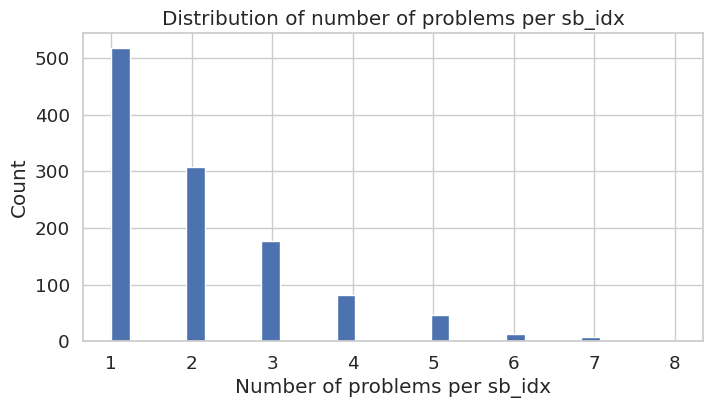

In [197]:
import matplotlib.pyplot as plt

sb_idx_counts = df_test_heart_test.groupby("sb_idx").size()
plt.figure(figsize=(8,4))
plt.hist(sb_idx_counts, bins=30)
plt.xlabel("Number of problems per sb_idx")
plt.ylabel("Count")
plt.title("Distribution of number of problems per sb_idx")
plt.show()

In [ ]:
df_test_heart_test.groupby("sb_idx").count()

,problem,N,beam_width,max_iteration,sl,token_count,time,method_beam_search,method_majority,method_naive,method_weighted,method,calibrated_probs
sb_idx,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5
1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,3,3,3,3,3,3,3,3,3,3,3,3,3
4,5,5,5,5,5,5,5,5,5,5,5,5,5
5,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9921,2,2,2,2,2,2,2,2,2,2,2,2,2
9941,2,2,2,2,2,2,2,2,2,2,2,2,2
9963,1,1,1,1,1,1,1,1,1,1,1,1,1


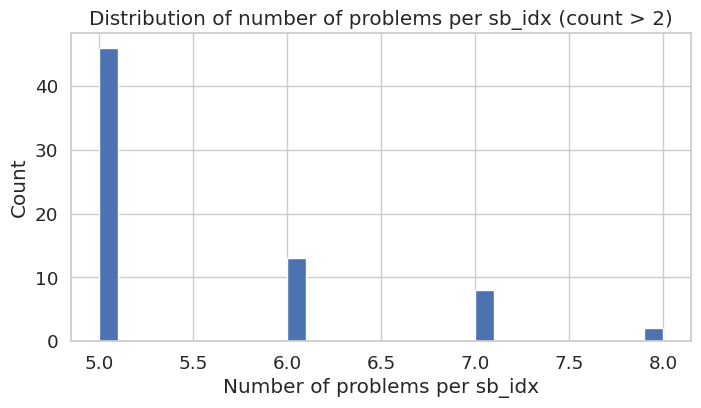

In [198]:
sb_idx_counts = df_test_heart_test.groupby("sb_idx").size()
filtered_counts = sb_idx_counts[sb_idx_counts >= 5]
plt.figure(figsize=(8,4))
plt.hist(filtered_counts, bins=30)
plt.xlabel("Number of problems per sb_idx")
plt.ylabel("Count")
plt.title("Distribution of number of problems per sb_idx (count > 2)")
plt.show()

In [206]:
# keep only sb_idx with at least 2 beam configs to choose between for routing.
# this is because there exists a certain subset of problems that have only 1 beam config, so routing is not possible.
df_test_filtered = df_test_heart_test[df_test_heart_test["sb_idx"].isin(filtered_counts.index)]

In [207]:
df_test_filtered.shape

(380, 14)

In [208]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test_filtered.groupby(["N", "beam_width", "max_iteration", "method"])[
    ["token_count", "time", "sl", "calibrated_probs"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

In [209]:
config_summary_df.head(10)

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs
0,2.0,0.0,0.0,majority,953.944444,2.362778,0.445556,0.590427
1,2.0,0.0,0.0,naive,1088.368421,2.861579,0.356842,0.469075
2,2.0,0.0,0.0,weighted,1201.423077,3.288462,0.325385,0.450264
3,2.0,2.0,40.0,beam_search,1353.500000,5.191667,0.166667,0.233931
4,2.0,4.0,40.0,beam_search,1429.800000,6.514667,0.334667,0.323283
5,4.0,0.0,0.0,majority,2161.318182,3.563182,0.467273,0.532980
6,4.0,0.0,0.0,naive,1982.608696,4.052609,0.546957,0.570630
7,4.0,0.0,0.0,weighted,2148.125000,3.875417,0.540833,0.542283
8,4.0,2.0,40.0,beam_search,4082.250000,12.977500,0.125000,0.259821
9,4.0,4.0,40.0,beam_search,3628.111111,9.666667,0.246667,0.264787


In [210]:
def compute_max_utility_pred(df, lambda_, method="oracle", cost="time"):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[cost]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[cost]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"]
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [211]:
def get_router_df(input_df, lambda_list, method="oracle", cost="time"):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, cost)
        average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean()
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "sl": average_accuracy,
            "token_count": average_cost,
            "predicted_prob": average_predicted_prob,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df


In [212]:
adaptive_tc = get_router_df(df_test_filtered, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", cost="token_count")
oracle_tc = get_router_df(df_test_filtered, lambda_list=np.logspace(-7, -1, num=50), method="oracle", cost="token_count")

adaptive_lat = get_router_df(df_test_filtered, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", cost="time")
oracle_lat = get_router_df(df_test_filtered, lambda_list=np.logspace(-5, -1, num=50), method="oracle", cost="time")

/tmp/ipykernel_904152/1882384397.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_904152/1882384397.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_904152/1882384397.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping colum

In [213]:
adaptive_tc.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-07,0.572947,15282.434783,0.573514,12.658551,adaptive_router
1,1.325711e-07,0.572947,14587.652174,0.573432,11.386957,adaptive_router
2,1.757511e-07,0.572947,13367.623188,0.573219,10.526957,adaptive_router
3,2.329952e-07,0.572947,12767.985507,0.573088,9.968696,adaptive_router
4,3.088844e-07,0.572947,12478.594203,0.573000,9.562319,adaptive_router


In [214]:
oracle_tc.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-07,0.690725,9255.898551,0.514147,10.926957,oracle
1,1.325711e-07,0.690725,9255.898551,0.514147,10.926957,oracle
2,1.757511e-07,0.690725,9255.898551,0.514147,10.926957,oracle
3,2.329952e-07,0.690725,9255.898551,0.514147,10.926957,oracle
4,3.088844e-07,0.690725,9255.898551,0.514147,10.926957,oracle


In [215]:
oracle_lat.head()

,lambda,sl,token_count,predicted_prob,time,method
0,0.000010,0.690725,9262.84058,0.514272,10.916812,oracle
1,0.000012,0.690725,9262.84058,0.514272,10.916812,oracle
2,0.000015,0.690725,9262.84058,0.514272,10.916812,oracle
3,0.000018,0.690725,9262.84058,0.514272,10.916812,oracle
4,0.000021,0.690725,9262.84058,0.514272,10.916812,oracle


In [216]:
adaptive_tc['N'] = -1
adaptive_tc['beam_width'] = -1
adaptive_tc['max_iteration'] = -1

adaptive_lat['N'] = -1
adaptive_lat['beam_width'] = -1
adaptive_lat['max_iteration'] = -1

oracle_tc['N'] = -1
oracle_tc['beam_width'] = -1
oracle_tc['max_iteration'] = -1

oracle_lat['N'] = -1
oracle_lat['beam_width'] = -1
oracle_lat['max_iteration'] = -1

In [217]:
config_summary_df.rename(columns={"calibrated_probs": "predicted_prob"}, inplace=True)

In [218]:
config_summary_df.head(25)

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
0,2.0,0.0,0.0,majority,953.944444,2.362778,0.445556,0.590427
1,2.0,0.0,0.0,naive,1088.368421,2.861579,0.356842,0.469075
2,2.0,0.0,0.0,weighted,1201.423077,3.288462,0.325385,0.450264
3,2.0,2.0,40.0,beam_search,1353.500000,5.191667,0.166667,0.233931
4,2.0,4.0,40.0,beam_search,1429.800000,6.514667,0.334667,0.323283
5,4.0,0.0,0.0,majority,2161.318182,3.563182,0.467273,0.532980
6,4.0,0.0,0.0,naive,1982.608696,4.052609,0.546957,0.570630
7,4.0,0.0,0.0,weighted,2148.125000,3.875417,0.540833,0.542283
8,4.0,2.0,40.0,beam_search,4082.250000,12.977500,0.125000,0.259821
9,4.0,4.0,40.0,beam_search,3628.111111,9.666667,0.246667,0.264787


In [219]:
config_summary_df[config_summary_df["method"] == "naive"]

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
1,2.0,0.0,0.0,naive,1088.368421,2.861579,0.356842,0.469075
6,4.0,0.0,0.0,naive,1982.608696,4.052609,0.546957,0.570630
11,8.0,0.0,0.0,naive,4357.526316,4.416842,0.456842,0.505679
16,16.0,0.0,0.0,naive,7505.800000,5.318000,0.580000,0.571428
22,32.0,0.0,0.0,naive,14870.550000,7.942500,0.668000,0.634722


In [220]:
oracle_tc.head()

,lambda,sl,token_count,predicted_prob,time,method,N,beam_width,max_iteration
0,1.000000e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
1,1.325711e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
2,1.757511e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
3,2.329952e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
4,3.088844e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1


In [221]:
# outer join on the shared columns
df_1_tc = pd.merge(
    adaptive_tc,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_2_tc = pd.merge(
    df_1_tc,
    oracle_tc,
    on=["lambda", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
# Replace NaN values with -1 for plotting purposes
query_optimal_tc = df_2_tc.fillna(-1)

In [223]:
# outer join on the shared columns
df_1_late = pd.merge(
    adaptive_lat,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_2_late = pd.merge(
    df_1_late,
    oracle_lat,
    on=["lambda", "method", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)

# Replace NaN values with -1 for plotting purposes
query_optimal_late = df_2_late.fillna(-1)

In [224]:
query_optimal_tc['method'].unique() 

array(['adaptive_router', 'oracle', 'beam_search', 'weighted', 'naive',
       'majority'], dtype=object)

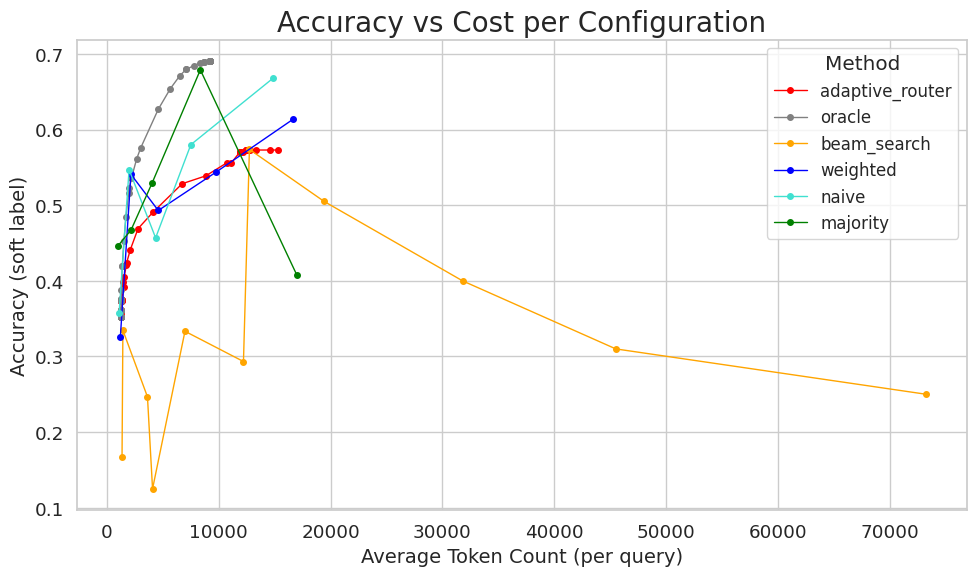

In [225]:
# Assign unique colors for each method
method_colors = {
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Token Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [149]:
config_summary_df[config_summary_df["method"] == "weighted"]

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
2,2.0,0.0,0.0,weighted,1051.289926,3.063661,0.475577,0.448851
7,4.0,0.0,0.0,weighted,2131.972222,3.677389,0.534778,0.454054
12,8.0,0.0,0.0,weighted,4394.471338,4.806943,0.529873,0.449289
17,16.0,0.0,0.0,weighted,9351.636015,6.778544,0.462222,0.462838
23,32.0,0.0,0.0,weighted,19871.315789,10.034928,0.414354,0.529731


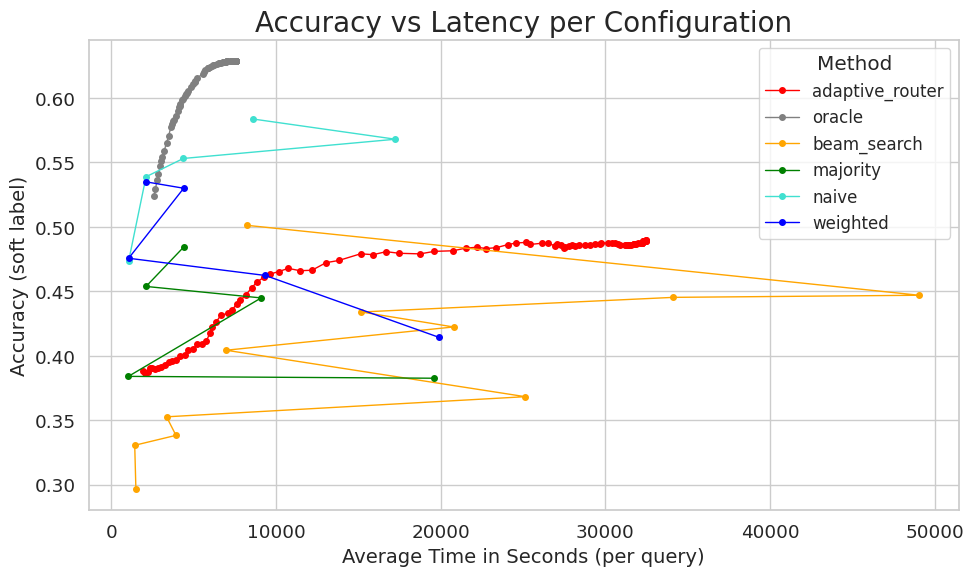

In [145]:
# Assign unique colors for each method
method_colors = {
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    method_df = query_optimal_late[query_optimal_late["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Time in Seconds (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Latency per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

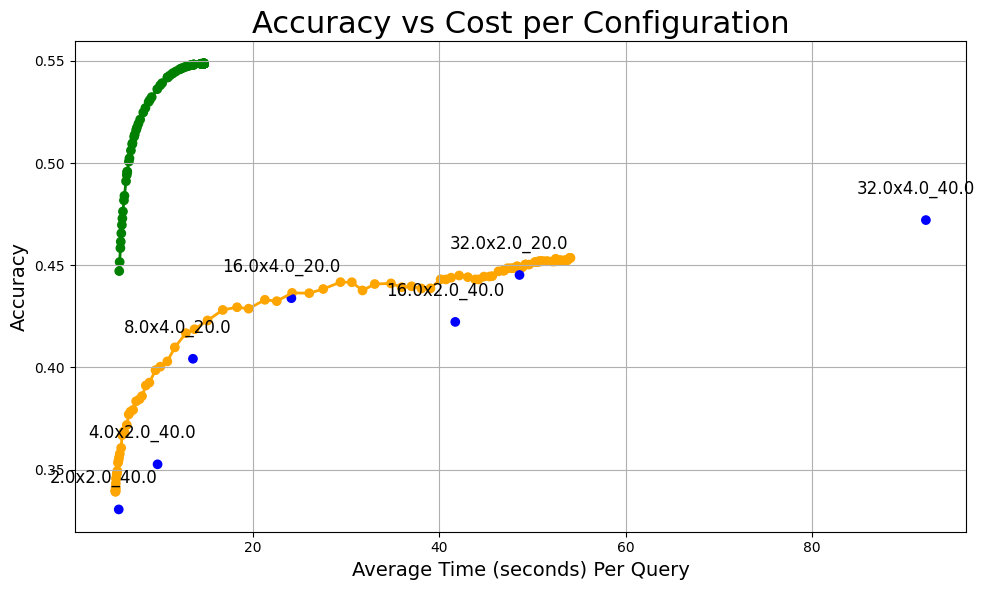

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create color labels and text labels
colors = [
    'orange' if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else 'green' if row['method'] == "oracle"
    else 'blue'
    for _, row in query_optimal_late.iterrows()
]

text_labels = [
    "qa" if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else None if row['method'] == "oracle"
    else f"{row['N']}x{row['beam_width']}_{row['max_iteration']}"
    for _, row in query_optimal_late.iterrows()
]

plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_late["time"], query_optimal_late["sl"], color=colors)

# Connect orange dots
orange_mask = [
    (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    for _, row in query_optimal_late.iterrows()
]
if any(orange_mask):
    orange_x = np.array(query_optimal_late["time"])[orange_mask]
    orange_y = np.array(query_optimal_late["sl"])[orange_mask]
    # If more than one, sort by x for a nice line
    if len(orange_x) > 1:
        idx = np.argsort(orange_x)
        plt.plot(orange_x[idx], orange_y[idx], color='orange', linewidth=2, zorder=1)

# Connect green dots
green_mask = [
    row['method'] == "oracle"
    for _, row in query_optimal_late.iterrows()
]
if any(green_mask):
    green_x = np.array(query_optimal_late["time"])[green_mask]
    green_y = np.array(query_optimal_late["sl"])[green_mask]
    if len(green_x) > 1:
        idx = np.argsort(green_x)
        plt.plot(green_x[idx], green_y[idx], color='green', linewidth=2, zorder=1)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_late["time"][i], query_optimal_late["sl"][i]),
                    textcoords="offset points", xytext=(-50, 19), ha='left', fontsize=12)

plt.xlabel("Average Time (seconds) Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=22)
plt.grid(True)
plt.tight_layout()

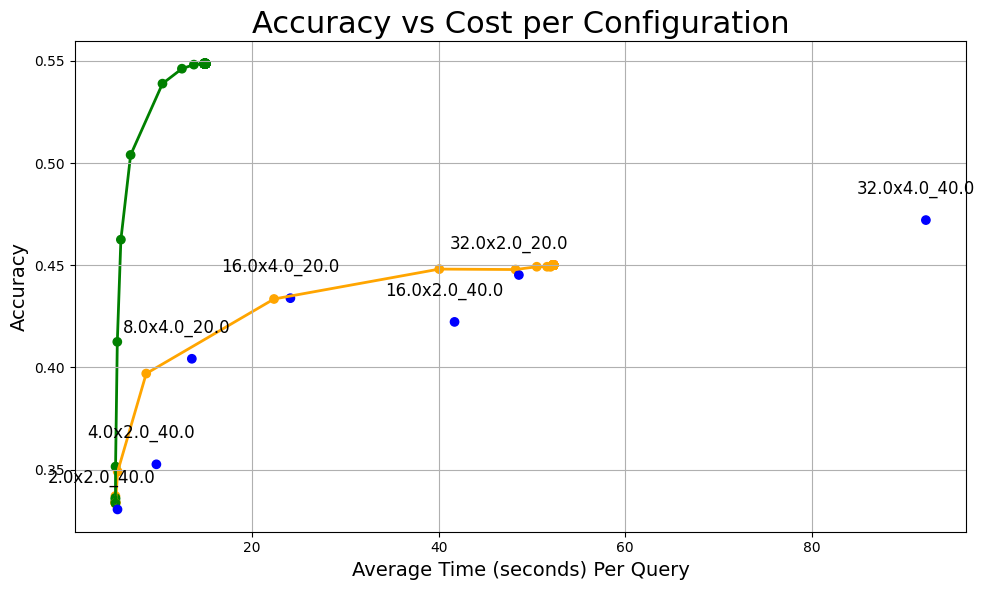

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create color labels and text labels
colors = [
    'orange' if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else 'green' if row['method'] == "oracle"
    else 'blue'
    for _, row in query_optimal_tc.iterrows()
]

text_labels = [
    "qa" if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else None if row['method'] == "oracle"
    else f"{row['N']}x{row['beam_width']}_{row['max_iteration']}"
    for _, row in query_optimal_tc.iterrows()
]

plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_tc["time"], query_optimal_tc["sl"], color=colors)

# Connect orange dots
orange_mask = [
    (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    for _, row in query_optimal_tc.iterrows()
]
if any(orange_mask):
    orange_x = np.array(query_optimal_tc["time"])[orange_mask]
    orange_y = np.array(query_optimal_tc["sl"])[orange_mask]
    # If more than one, sort by x for a nice line
    if len(orange_x) > 1:
        idx = np.argsort(orange_x)
        plt.plot(orange_x[idx], orange_y[idx], color='orange', linewidth=2, zorder=1)

# Connect green dots
green_mask = [
    row['method'] == "oracle"
    for _, row in query_optimal_tc.iterrows()
]
if any(green_mask):
    green_x = np.array(query_optimal_tc["time"])[green_mask]
    green_y = np.array(query_optimal_tc["sl"])[green_mask]
    if len(green_x) > 1:
        idx = np.argsort(green_x)
        plt.plot(green_x[idx], green_y[idx], color='green', linewidth=2, zorder=1)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_tc["time"][i], query_optimal_tc["sl"][i]),
                    textcoords="offset points", xytext=(-50, 19), ha='left', fontsize=12)

plt.xlabel("Average Time (seconds) Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=22)
plt.grid(True)
plt.tight_layout()

To Try Out Next:

- join with other methods.

- run larger beam sizes.

- calibrate model!

- indicators rather than accuracy.

- use pred probabilities as predictions.

#### Beam Times for Small vs. Large N Beam.

In [ ]:
import re
import numpy as np

def extract_average_beam_search_time(log_file_path):
    """
    Extract all "Total beam search time:" values from a log file and calculate the average.
    
    Args:
        log_file_path (str): Path to the log file
        
    Returns:
        dict: Dictionary containing:
            - 'times': List of all beam search times in seconds
            - 'average': Average beam search time in seconds
            - 'count': Number of beam search operations
            - 'min': Minimum beam search time
            - 'max': Maximum beam search time
            - 'std': Standard deviation of beam search times
    """
    # Pattern to match "Total beam search time: X.XX seconds."
    pattern = r'Total beam search time: ([\d.]+) seconds\.'
    
    times = []
    
    try:
        with open(log_file_path, 'r') as file:
            for line in file:
                match = re.search(pattern, line)
                if match:
                    time_value = float(match.group(1))
                    times.append(time_value)
    except FileNotFoundError:
        print(f"Error: File '{log_file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
    if not times:
        print("No beam search times found in the log file.")
        return None
    
    # Calculate statistics
    times_array = np.array(times)
    result = {
        'times': times,
        'average': np.mean(times_array),
        'count': len(times),
        'min': np.min(times_array),
        'max': np.max(times_array),
        'std': np.std(times_array)
    }
    
    return result


In [ ]:
# Test the function
result = extract_average_beam_search_time('/dccstor/gma2/jhjenny9/search-and-learn/large-beam-2.out')

print(f"Beam Time for N=128")
print(f"Found {result['count']} beam search operations")
print(f"Average time: {result['average']:.2f} seconds")
print(f"Min time: {result['min']:.2f} seconds")
print(f"Max time: {result['max']:.2f} seconds")
print(f"Standard deviation: {result['std']:.2f} seconds")
print(f"\nAll times: {result['times']}")

Beam Time for N=128
Found 10 beam search operations
Average time: 388.20 seconds
Min time: 133.41 seconds
Max time: 616.34 seconds
Standard deviation: 123.20 seconds

All times: [297.57, 403.46, 403.98, 415.98, 133.41, 616.34, 359.12, 514.49, 431.28, 306.37]


In [ ]:
# Test the function
result = extract_average_beam_search_time('/dccstor/gma2/jhjenny9/search-and-learn/large-beam.out')

print(f"Beam Time for N=32")
print(f"Found {result['count']} beam search operations")
print(f"Average time: {result['average']:.2f} seconds")
print(f"Min time: {result['min']:.2f} seconds")
print(f"Max time: {result['max']:.2f} seconds")
print(f"Standard deviation: {result['std']:.2f} seconds")
print(f"\nAll times: {result['times']}")

Beam Time for N=32
Found 100 beam search operations
Average time: 81.80 seconds
Min time: 10.66 seconds
Max time: 264.00 seconds
Standard deviation: 57.81 seconds

All times: [24.76, 19.27, 99.12, 95.19, 26.03, 78.23, 13.39, 31.76, 134.76, 11.11, 56.41, 121.37, 109.11, 18.25, 264.0, 23.91, 62.78, 65.45, 64.4, 48.95, 118.92, 120.7, 24.39, 70.16, 160.42, 25.36, 167.64, 103.07, 88.3, 13.57, 27.39, 85.95, 21.11, 37.36, 41.51, 78.14, 77.44, 123.13, 122.26, 24.13, 20.46, 99.25, 21.17, 75.69, 24.67, 15.8, 19.05, 43.24, 115.7, 135.53, 67.32, 125.27, 73.35, 81.99, 224.16, 52.6, 103.65, 67.62, 130.81, 175.54, 21.22, 120.32, 176.65, 16.03, 105.63, 90.8, 23.85, 31.28, 36.32, 26.99, 91.97, 111.23, 217.35, 101.09, 35.78, 12.05, 51.53, 110.73, 189.84, 19.03, 11.21, 144.93, 16.41, 42.49, 98.03, 197.02, 102.67, 90.83, 139.4, 173.64, 77.79, 120.7, 82.18, 32.01, 40.53, 134.08, 104.03, 177.38, 222.48, 10.66]
